In [86]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)
data_kev = nested_dict(5, list)

data_kgb_l = nested_dict(5, list)
data_kgb_s = nested_dict(5, list)

import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

# Simulations

In [128]:
path_kev = "/home/ahmad/Desktop/cluster/Farbods_simulations/Kevolution/9000Boxsize-cs_e7-w09-Kevolution/output"
data_kev = np.loadtxt(path_kev+'/kess_pk_cs_e7_w09_large020_delta.dat')
data_kev_DE = np.loadtxt(path_kev+'/kess_pk_cs_e7_w09_large020_delta_kess.dat')



# path_kev = "/home/ahmad/Desktop/cluster/Yggdrasil/2048^3_2Gp"
# data_kev = np.loadtxt(path_kev+'/pk_019_delta.dat')
# data_kev_DE = np.loadtxt(path_kev+'/pk_019_delta_kess.dat')

z = [0.08]


kk_kev_sim = data_kev[:, 0]
pk_kev = data_kev[:, 1]
pk_kev_DE = data_kev_DE[:, 1]

norm = (2 * (np.pi) ** 2) / ((kk_kev_sim) ** 3)


pk_kev_sim = norm * pk_kev
pk_kev_sim_DE =  pk_kev_DE

# CLASS

In [129]:
class_Pk_m_kess = [None] * len(z)
class_Pk_smg_kess = [None] * len(z)


kess_settings ={
        "Omega_scf": 0,
        "Omega_Lambda": 0,
        "cs2_fld": 1e-7,
        "w0_fld": -0.9,
        "wa_fld":0,
        "h": 0.67556,
        "omega_b": 0.022032,
        "omega_cdm": 0.12038,
        "A_s": 2.215e-9,
        "n_s": 0.9619,
        "z_max_pk": 100,
        "tau_reio": 0.05430842,
        "N_ur":3.046,
        #"non linear":"halofit",
        "output": "dTk,vTk,mPk",
        "use_ppf":"yes",
        "P_k_max_1/Mpc": 192,
    }

M_kess = Class()
M_kess.set(kess_settings)
M_kess.compute()


kk = kk_kev_sim
k_pivot = 0.05
h = M_kess.h()
As = kess_settings["A_s"]
ns = kess_settings["n_s"]
Normalization = As * (kk / k_pivot) ** (ns - 1.0)

backgrounds = M_kess.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_fld = interp1d(backgrounds["z"], backgrounds["(.)rho_fld"], kind="cubic")
w_fld = interp1d(backgrounds["z"], backgrounds["(.)w_fld"], kind="cubic")


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kess.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"   
    )
    
    ############
    
    delta_fld = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_fld"], kind="cubic"
    )

    theta_fld = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_fld"], kind="cubic"   
    )
   #############

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")



    tmp_m_kess = []
    tmp_smg_kess = []


    for k in kk:
        
        tmp_m_kess.append(M_kess.pk(k * h, z_val) * h**3)
        tmp_smg_kess.append(delta_fld(k)**2)
        
#########################################################################################################
#                                        Calculating Spectra
        
  ### matter power spectrum  

    # using the direct function
    class_Pk_m_kess[zind] = tmp_m_kess
    
 #### DE power spectrum
    class_Pk_smg_kess[zind] = Normalization * np.array(tmp_smg_kess)


In [123]:
# def a(x):
#     return 1/(1+x)

# alpha_K_hat = 3e+06
# alpha_B_hat = 0

# hiclass KGB

In [130]:
Pk_m_kgb = [None] * len(z)
Pk_smg_kgb = [None] * len(z)

#######################################################################################
#                                               KGB settings
kgb_settings = {
    "Omega_smg": -1,
    "Omega_Lambda": 0,
    "Omega_fld": 0,
    "h": 0.67556,
    "omega_b": 0.022032,
    "omega_cdm": 0.12038,
    "A_s": 2.215e-9,
    "n_s": 0.9619,
    "z_max_pk": 100,
    "tau_reio": 0.05430842,
    "gravity_model": "propto_omega",
    "parameters_smg": f"{alpha_K_hat}, {alpha_B_hat}, 0, 0, 1",
    "expansion_model": "w0wa",
    "expansion_smg": f"0.687862,-0.9, 0",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}


M_kgb = Class()
M_kgb.set(kgb_settings)
M_kgb.compute()
######################################################################################


######################################################################################
#                                                 common parameters

#kk = np.logspace(-3.2, np.log10(10), 1000)  # k in h/Mpc
kk = kk_kev_sim
k_pivot = 0.05
h = M_kgb.h()
As = kgb_settings["A_s"]
ns = kgb_settings["n_s"]
Normalization = As * (kk / k_pivot) ** (ns - 1.0)

######################################################################################
#                                                    backgrounds

backgrounds = M_kgb.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)

############################################################################################


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kgb.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kgb = []
    tmp_m_kgb_newt = []
    tmp_smg_kgb = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = (
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        
        # gauge transformation
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        delta_cdm_newt = delta_cdm(k) - alpha * 3*Hconf(z_val)
        
        
        
        tmp_m_kgb.append(M_kgb.pk(k * h, z_val) * h**3)
        
        tmp_m_kgb_newt.append(delta_cdm_newt**2)
        tmp_smg_kgb.append(delta_smg_syn**2)
        
#########################################################################################################
#                                        Calculating Spectra
        
  ### matter power spectrum  

    # using transfer function
    Pk_m_kgb[zind] = 2* (np.pi**2)/((kk)**3) * Normalization * tmp_m_kgb_newt
    
    # using the direct function
    Pk_m_kgb[zind] = tmp_m_kgb
    
 #### DE power spectrum
    Pk_smg_kgb[zind] = Normalization * np.array(tmp_smg_kgb)



# hiclass kessence

In [131]:
hi_Pk_m_kess = [None] * len(z)
hi_Pk_smg_kess = [None] * len(z)


#######################################################################################
#                                               kessence settings

kess_settings = kgb_settings.copy()
kess_settings["parameters_smg"] = f"{alpha_K_hat}, 0, 0, 0, 1"
#kess_settings["use_ppf"] = "yes"
M_kess = Class()
M_kess.set(kess_settings)
M_kess.compute()

####################################################################################

######################################################################################
#                                                    backgrounds

backgrounds = M_kess.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")

a_hi = 1.0 / (1.0 + backgrounds["z"])
a_hiclass = interp1d(backgrounds["z"], a_hi, kind="cubic")
z_hi = backgrounds["z"]

Hconf = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"] * a_hi)
Hconf_prime = interp1d(
    backgrounds["z"],
    (a_hi**2) * (backgrounds["H [1/Mpc]"] ** 2) + a_hi * backgrounds["H_prime"],
)

H0 = Hconf(0)
Mpl2 = 1 / (3.0 * H0** 2)


for zind, z_val in enumerate(z):

    #######################################################################################
    #                                                 Transfer functions

    Transfers = M_kess.get_transfer(z_val)

    #############
    delta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_b"], kind="cubic"
    )
    theta_b = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_cdm"], kind="cubic"
    )
    #############
    delta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_g"], kind="cubic"
    )
    theta_g = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_g"], kind="cubic"
    )
    #############
    delta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_ur"], kind="cubic"
    )
    theta_ur = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_ur"], kind="cubic"
    )
    #############

    delta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["d_tot"], kind="cubic"
    )

    theta_tot = interp1d(
        Transfers["k (h/Mpc)"], Transfers["t_tot"], kind="cubic"
    )

    phi = interp1d(Transfers["k (h/Mpc)"], Transfers["phi"], kind="cubic")
    phi_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["phi_prime"], kind="cubic"
    )
    psi = interp1d(Transfers["k (h/Mpc)"], Transfers["psi"], kind="cubic")

    vx_smg = interp1d(Transfers["k (h/Mpc)"], Transfers["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers["k (h/Mpc)"], Transfers["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers["k (h/Mpc)"], Transfers["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers["k (h/Mpc)"], Transfers["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers["k (h/Mpc)"], Transfers["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers["k (h/Mpc)"], Transfers["h_prime"], kind="cubic"
    )


    tmp_m_kess = []
    tmp_smg_kess = []


    for k in kk:
        
        alpha = (h_prime_met(k) + 6.0 * eta_prime(k)) / (2.0 * k * k * h * h)
        alpha_prime = psi(k) - Hconf(z_val) * alpha

        pi_newt = -vx_smg(k) + alpha
        pi_prime_newt = -vx_prime_smg(k) + alpha_prime
        zeta_newt = Hconf(z_val) * pi_newt + pi_prime_newt - psi(k)

        delta_smg_newt = (
            (Mpl2 / a(z_val) ** 2)
            * (
                -alpha_B(z_val) * Hconf(z_val) * ((k * h) ** 2) * pi_newt
                + 3 * alpha_B(z_val) * (Hconf(z_val) ** 2) * psi(k)
                - (3 * alpha_B(z_val) + alpha_K(z_val))
                * (Hconf(z_val) ** 2)
                * zeta_newt
                + 3 * alpha_B(z_val) * Hconf(z_val) * phi_prime(k)
            )
            + (
                (Mpl2 * alpha_B(z_val) / (a(z_val) ** 2))
                * (Hconf_prime(z_val) - Hconf(z_val) ** 2)
                + ((rho_smg(z_val) + p_smg(z_val)) / H0**2)
            )
            * 3
            * Hconf(z_val)
            * pi_newt
        ) / (rho_smg(z_val) / H0**2)
        
        delta_smg_syn = delta_smg_newt + alpha * rho_smg_prime(z_val) / rho_smg(z_val)
        
        
        
        tmp_m_kess.append(M_kess.pk(k * h, z_val) * h**3)
        
        tmp_smg_kess.append(delta_smg_syn**2)
        
  ### matter power spectrum  
    hi_Pk_m_kess[zind] = tmp_m_kess
    
 #### DE power spectrum
    hi_Pk_smg_kess[zind] = Normalization * np.array(tmp_smg_kess)



# matter power spectrum

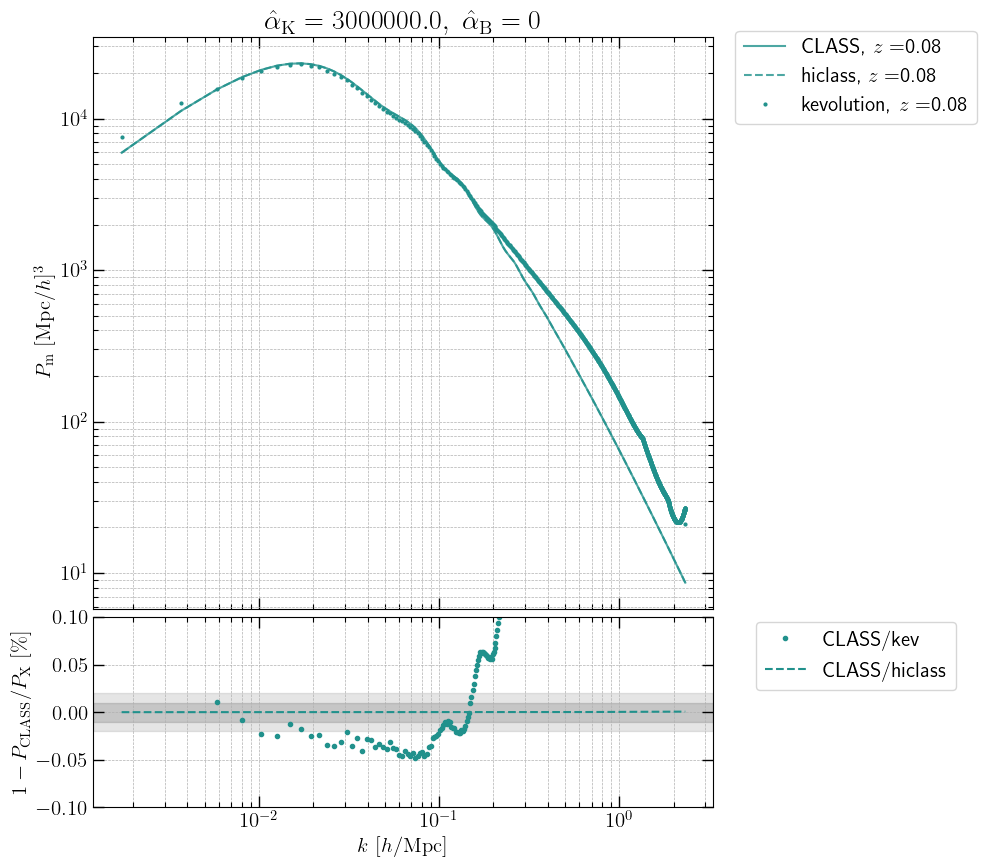

In [132]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}



####################################################################################################
    #                                         KGB     

for zind, zval in enumerate(z):
    

    
    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        kk,
        class_Pk_m_kess[zind],"-",
        c = c[zind],
        label="CLASS, $z=$" + str(z[zind]),
        alpha = 0.8,
        markersize=6
    )
    
    ax[0].plot(
        kk,
        hi_Pk_m_kess[zind],"--",
        c = c[zind],
        label="hiclass, $z=$" + str(z[zind]),
        alpha = 0.8,
        markersize=6
    )
    
    
    ax[0].plot(
        kk,
        pk_kev_sim,"o",
        c = c[zind],
        label="kevolution, $z=$" + str(z[zind]),
        markersize=2
    )
    

    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(class_Pk_m_kess[zind])/pk_kev_sim),"o",
        c = c[zind],
        label = "CLASS/kev",
        markersize=3
    )
    
    ax[1].plot(
        kk,
        (1-class_Pk_m_kess[zind]/np.array(hi_Pk_m_kess[zind])),"--",
        c = c[zind],
        label = "CLASS/hiclass",
        markersize=3
    )
    



ax[1].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
ax[1].axhspan(-0.02, 0.02, color="gray", alpha=0.2)


#ax[1].set_yscale("symlog", linthresh=0.02)
ax[1].set_ylim(-0.1,0.1)

    
    

for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_\mathrm{m}~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{CLASS}/P_\mathrm{X}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[1].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)

ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")

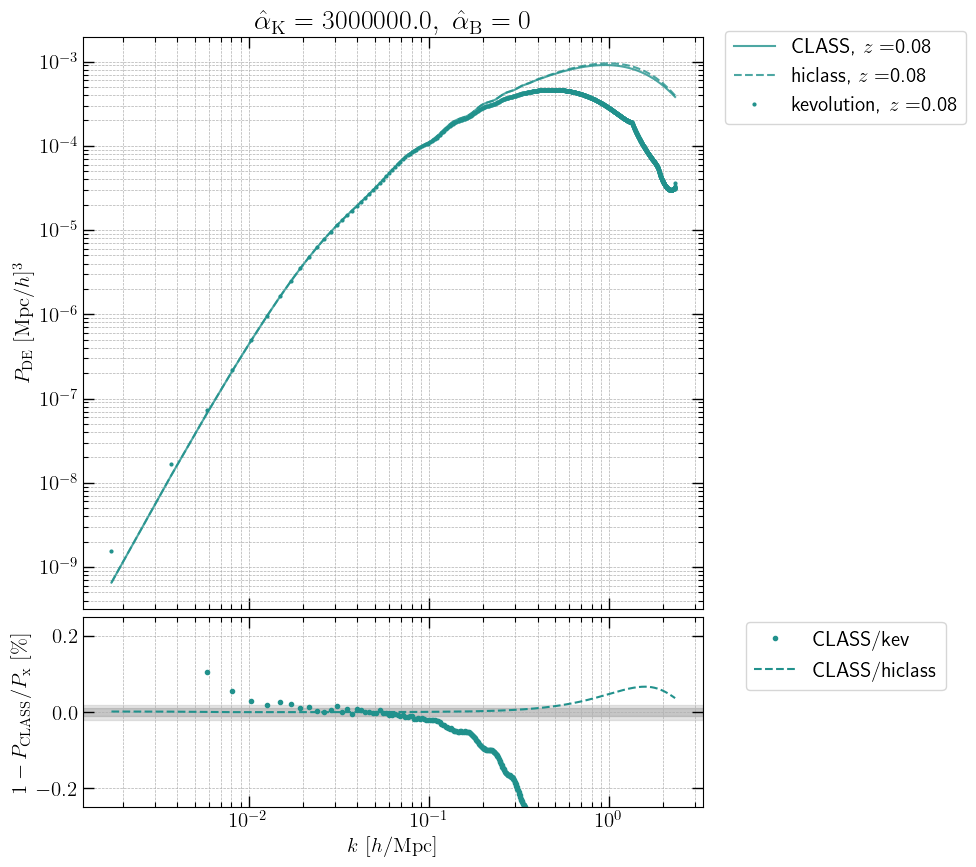

In [133]:
fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}



####################################################################################################
    #                                         KGB     

for zind, zval in enumerate(z):
    

    
    #############################################################################
    #                                         hiclass
    
    
    ax[0].plot(
        kk,
        class_Pk_smg_kess[zind],"-",
        c = c[zind],
        label="CLASS, $z=$" + str(z[zind]),
        alpha = 0.8,
        markersize=6
    )
    
    ax[0].plot(
        kk,
        hi_Pk_smg_kess[zind],"--",
        c = c[zind],
        label="hiclass, $z=$" + str(z[zind]),
        alpha = 0.8,
        markersize=6
    )
    
    
    
    ax[0].plot(
        kk,
        pk_kev_sim_DE,"o",
        c = c[zind],
        label="kevolution, $z=$" + str(z[zind]),
        markersize=2
    )
    

    ##############################################################################
    #                                         Rel Diff
    
    ax[1].plot(
        kk,
        (1-np.array(class_Pk_smg_kess[zind])/pk_kev_sim_DE),"o",
        c = c[zind],
        label = "CLASS/kev",
        markersize=3
    )
    
    
    ax[1].plot(
        kk,
        (1-class_Pk_smg_kess[zind]/np.array(hi_Pk_smg_kess[zind])),"--",
        c = c[zind],
        label = "CLASS/hiclass",
        markersize=3
    )



ax[1].axhspan(-0.01, 0.01, color="gray", alpha=0.3)
ax[1].axhspan(-0.02, 0.02, color="gray", alpha=0.2)


#ax[1].set_yscale("symlog", linthresh=0.02)
ax[1].set_ylim(-0.25,0.25)

    
    

for i in range(2):
    ax[i].set_xscale("log")
    

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)


    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_\mathrm{DE}~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{CLASS}/P_\mathrm{x}~ [\%]$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)



ax[1].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)


ax[0].set_title(
    rf"$\hat{{\alpha}}_{{\mathrm{{K}}}} = {alpha_K_hat},\ \hat{{\alpha}}_{{\mathrm{{B}}}} = {alpha_B_hat}$",
    fontsize=20,
)


plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}

#save_fig("matter_power_spectrum")